In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-173.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-334.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-309.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-487.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-178.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png
/kaggle/input/tuberculos

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, ReLU, concatenate, Dropout,AvgPool2D,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Retrieving Data

In [3]:
url = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

In [4]:
data = pathlib.Path(url)

# Spliting Data

In [5]:
# AGMENTING DATA
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2) 
# Training 
batch_size = 16  
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='binary',  
    subset='training'
)

# Validating
validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='binary',  
    subset='validation'
)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [6]:
labels = {
    0 : "Normal",
    1 : "Tuberculosis"
}

# Visualizing Data

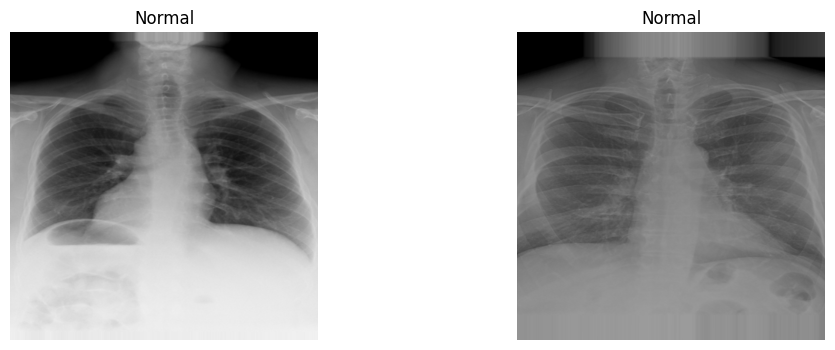

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Assuming train_generator is a DirectoryIterator or similar object
batch = next(train_generator)

for i in range(2):
    sub = plt.subplot(1, 2, i + 1)
    plt.imshow(batch[0][i])  # Try without astype("uint8")
    plt.title(labels[batch[1][i]])
    plt.axis("off")

plt.show()


# SquezzNet

In [8]:
def fire_module(x, s1, e1, e3):
    s1x = Conv2D(s1, kernel_size=1, padding='same')(x)
    s1x = ReLU()(s1x)
    e1x = Conv2D(e1, kernel_size=1, padding='same')(s1x)
    e3x = Conv2D(e3, kernel_size=3, padding='same')(s1x)
    x = concatenate([e1x, e3x])
    x = ReLU()(x)
    return x

def SqueezeNet(input_shape, nclasses):
    input = Input(input_shape)
    x = Conv2D(96, kernel_size=(7, 7), strides=(2, 2), padding='same')(input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, s1=16, e1=64, e3=64)  # 2
    x = fire_module(x, s1=16, e1=64, e3=64)  # 3
    x = fire_module(x, s1=32, e1=128, e3=128)  # 4
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, s1=32, e1=128, e3=128)  # 5
    x = fire_module(x, s1=48, e1=192, e3=192)  # 6
    x = fire_module(x, s1=48, e1=192, e3=192)  # 7
    x = fire_module(x, s1=64, e1=256, e3=256)  # 8
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, s1=64, e1=256, e3=256)  # 9
    x = Dropout(0.5)(x)
    x = Conv2D(nclasses, kernel_size=1)(x)
    output = AvgPool2D(pool_size=(13, 13))(x)
    model = Model(input, output)
    return model

# Assuming binary classification
model_squeez = SqueezeNet(input_shape=(512, 512, 3), nclasses=1)
model_squeez.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = model_squeez.fit(train_generator, epochs=3, validation_data=validation_generator)


Epoch 1/3
210/210 [==============================] - 1751s 8s/step - loss: 2.5708 - accuracy: 0.8333 - val_loss: 2.5708 - val_accuracy: 0.8333
Epoch 2/3
210/210 [==============================] - 1720s 8s/step - loss: 2.5708 - accuracy: 0.8333 - val_loss: 2.5708 - val_accuracy: 0.8333
Epoch 3/3
210/210 [==============================] - 1722s 8s/step - loss: 2.5708 - accuracy: 0.8333 - val_loss: 2.5708 - val_accuracy: 0.8333
